In [19]:
import transformers
import numpy as np 
import pandas as pd 
import re
import pickle 
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model
import torch
import torch.nn as nn
from IPython.display import FileLink
from transformers import Trainer, TrainingArguments

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2024-04-13 11:06:30.825451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 11:06:30.825568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 11:06:30.964189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/vk-anekdots/anekdots_result.csv
/kaggle/input/gpt2-tuned-lora/transformers/v1/1/gpt-2/adapter_model.safetensors
/kaggle/input/gpt2-tuned-lora/transformers/v1/1/gpt-2/adapter_config.json
/kaggle/input/gpt2-tuned-lora/transformers/v1/1/gpt-2/README.md
/kaggle/input/russian-jokes/jokes.csv


In [2]:
!pip install peft -q

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")

device is cuda:0


In [4]:
texts = pd.read_csv('../input/russian-jokes/jokes.csv')['text']
added_texts = pd.read_csv('../input/vk-anekdots/anekdots_result.csv')['text']
data = pd.concat([texts, added_texts], axis=0).reset_index().drop('index', axis=1)
str_lenghts = data['text'].str.len()
small_indexes = (str_lenghts <= str_lenghts.quantile(q=0.9))
data = data[small_indexes]
data = data.reset_index(drop=True)
unique_ind = data['text'].apply(lambda x: re.sub(r'[^а-я0-9]', '', x.lower())).drop_duplicates().index.values
data = data.iloc[unique_ind]
data = data.reset_index(drop=True)
data

,text
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...
1,"- Вы продолжаете утверждать, что обвиняемый н..."
2,"На суде.\r\n- Итак, когда дело дошло до столкн..."
3,Старую леди сбил автомобиль. На суде ее спраши...
4,"Судья говорит:\r\n- Согласно вашей жалобе, об..."
...,...
321525,"Позвонил друг, поделился восторгом.\nОн себе с..."
321526,Реальное объявление в мастерской по ремонту об...
321527,Не так давно предлагаю ребёнку отгадать извест...
321528,"Лежим с женой в спальне, смотрим романтическую..."


In [5]:
data['text'] = data['text'].apply(lambda x: x.replace('\r', '').replace('\n', ''))

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side='left')
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [7]:
def texts_to_batch_train(texts) -> torch.Tensor:
    batch = tokenizer(
        text=texts,
        return_tensors="pt",
        add_special_tokens=True,
        padding='max_length',
        truncation=True
      )
    return batch

In [8]:
llm_model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
llm_model.eval()
llm_model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
inputs = tokenizer(["Встретились как-то русский и американец", "Сидит штирлиц в засаде"], 
                   return_tensors="pt", padding=True).to(device)
outputs = llm_model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
[tokenizer.decode(output) for output in outputs]

['Встретились как-то русский и американеция в простретились как-то русский и аме',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Сидит штирлиц в засадение в засадение в засадение в засадение �']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test = train_test_split(data['text'].values, test_size=0.001, random_state=42)
len(X_train), len(X_test)

(321208, 322)

In [12]:
train_loader = torch.utils.data.DataLoader(
    dataset = X_train,
    batch_size = 3,
    shuffle = True,
    drop_last = True,
    collate_fn = texts_to_batch_train
)
val_loader = torch.utils.data.DataLoader(
    dataset = X_test,
    batch_size = 1,
    shuffle = True,
    drop_last = True,
    collate_fn = texts_to_batch_train
)

In [29]:
data['text'].apply(lambda s: len(s.split(' '))).describe()

count    321530.000000
mean         24.781768
std          17.830177
min           1.000000
25%          12.000000
50%          19.000000
75%          32.000000
max         240.000000
Name: text, dtype: float64

In [15]:
OUTPUT_SIZE = 32

In [16]:
!pip install torcheval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [17]:
from torcheval.metrics.functional import multiclass_accuracy
from IPython.display import clear_output


In [18]:
def show(train_losses, val_losses, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    axes[0].plot(range(0, len(train_losses)), train_losses, label='Train loss')
    axes[0].plot(range(0, len(val_losses)), val_losses, label='Val loss')
    axes[0].legend()
    axes[0].grid()
    axes[1].plot(range(0, len(val_acc)), val_acc, label='Vall accuracy')
    axes[1].legend()
    axes[1].grid()
    fig.suptitle('GPT2')
    plt.show()

In [17]:
def train(
    llm,
    tokenizer,
    n_iters,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""
    train_losses = []
    val_losses = []
    val_acc = []
    n_iter = 0
    for batch in tqdm(train_loader):
        llm.train()
        input_tokens = batch['input_ids'][:, :-1].to(device)
        labels = batch['input_ids'].clone()[:, 1:].to(device)
        attention_mask = batch['attention_mask'][:, :-1].to(device)

        out_logits = llm_model(input_ids=input_tokens, attention_mask=attention_mask).logits
        labels[labels == tokenizer.pad_token_id] = -100
        loss_value = criterion(out_logits.permute(0, 2, 1), labels)

        loss = loss_value.item()
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        train_losses.append(loss)

        llm_model.eval() 

        loss = 0
        acc = 0
        for batch in val_loader:
            batch = batch.to(device)
            input_tokens = batch['input_ids'][:, :-1]
            labels = batch['input_ids'].clone()[:, 1:]
            attention_mask = batch['attention_mask'][:, :-1]

            out_logits = llm_model(input_ids=input_tokens, attention_mask=attention_mask).logits
            labels[labels == tokenizer.pad_token_id] = -100
            acc = multiclass_accuracy(out_logits[0], labels[0]).item()
            loss_value = criterion(out_logits.permute(0, 2, 1), labels)
            loss = loss_value.item()

        acc /= len(val_loader.dataset)
        loss /= len(val_loader.dataset)

        val_losses.append(loss)
        val_acc.append(acc)
        clear_output(wait=True)
        show(train_losses, val_losses, val_acc)
        n_iter += 1
        if n_iter == n_iters:
            break

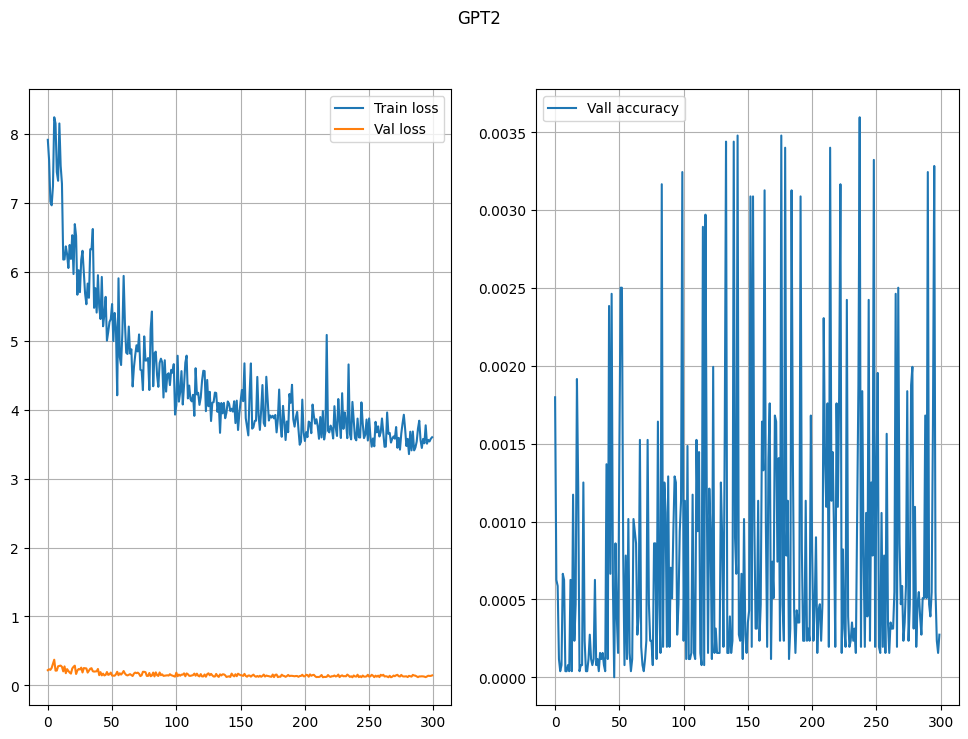

  0%|          | 299/107168 [23:21<139:10:53,  4.69s/it]


In [18]:
loss = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.AdamW(
    params=llm_model.parameters(), lr=1e-6
)
llm_model = llm_model.to(device)
train(llm_model, tokenizer, 300, loss, optimizer, train_loader, val_loader)

In [22]:
llm_model.save_pretrained('models/tuned_gpt2')

Обучение было произведено на сервере

### Дообучаемся с помощью Lora

In [11]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side='left')
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [12]:
llm_model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
llm_model.eval()
llm_model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [19]:
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training

lora_config = LoraConfig(
    task_type='CAUSAL_LM',
    r=1,
    target_modules=['c_attn'],
    lora_dropout=0.05
)

llm_model.gradient_checkpointing_enable()
llm_model.enable_input_require_grads()

model = get_peft_model(llm_model, lora_config)

model.print_trainable_parameters()

trainable params: 36,864 || all params: 124,476,672 || trainable%: 0.029615187655402612


In [20]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=1, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=1, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
         

In [43]:
train_args = TrainingArguments(
    output_dir='output',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=1,
    save_strategy="no",
    report_to="none",
    warmup_ratio=0.0,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    max_steps=1300
)


In [22]:
def data_collator(texts) -> torch.Tensor:
    batch = tokenizer(
        text=texts,
        return_tensors="pt",
        add_special_tokens=True,
        padding='max_length',
        truncation=True
      )
    return {
            'input_ids': batch['input_ids'].clone()[:, :-1],
            'labels': batch['input_ids'].clone()[:, 1:],
            'attention_mask': batch['attention_mask'][:, :-1]
    }

In [44]:
trainer = Trainer(
    model,
    train_args,
    tokenizer=tokenizer,
    train_dataset=X_train,
    eval_dataset=X_test,
    data_collator=data_collator
)

In [45]:
trainer.train()

Step,Training Loss
1,1.723400
2,1.859300
3,1.688500
4,1.431900
5,1.622000
6,1.511900
7,1.480900
8,1.299400
9,1.683400
10,1.545300


TrainOutput(global_step=1300, training_loss=0.8607986584076515, metrics={'train_runtime': 4075.0447, 'train_samples_per_second': 5.104, 'train_steps_per_second': 0.319, 'total_flos': 1.08638399840256e+16, 'train_loss': 0.8607986584076515, 'epoch': 0.06})

In [47]:
model.save_pretrained("output_dir")

In [48]:
!zip -r file.zip /kaggle/working/output_dir
FileLink(r'file.zip')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/output_dir/ (stored 0%)
  adding: kaggle/working/output_dir/adapter_model.safetensors (deflated 9%)
  adding: kaggle/working/output_dir/adapter_config.json (deflated 52%)
  adding: kaggle/working/output_dir/README.md (deflated 66%)


/kaggle/working/file.zip

In [49]:
inputs = tokenizer(["Встретились как-то русский и американец", "Сидит штирлиц в засаде"], 
                   return_tensors="pt", padding=True).to(device)
outputs = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
[tokenizer.decode(output) for output in outputs]

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['Встретились как-то русский и американецииеиииеиииииииииииииииииииииииииииииииии',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Сидит штирлиц в засаде�ее��и�е��������������������������������']

In [50]:
trainer.train()
model.save_pretrained("output_dir")
!zip -r file.zip /kaggle/working/output_dir
FileLink(r'file.zip')

Step,Training Loss
1,0.841800
2,0.983500
3,0.750500
4,0.665400
5,0.823800
6,0.782100
7,0.778300
8,0.693400
9,0.951400
10,0.866000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: kaggle/working/output_dir/ (stored 0%)
updating: kaggle/working/output_dir/adapter_model.safetensors (deflated 9%)
updating: kaggle/working/output_dir/adapter_config.json (deflated 52%)
updating: kaggle/working/output_dir/README.md (deflated 66%)


/kaggle/working/file.zip

In [54]:
inputs = tokenizer(["Заходит человек в бар", "Как-то раз"], 
                   return_tensors="pt", padding=True).to(device)
outputs = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
[tokenizer.decode(output) for output in outputs]

['Заходит человек в бар����ии �т�тЇ� �и � �ии��� � �тии �<|endoftext|>',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Как-то раз �тнто � ����� � ��т���ттит��<|endoftext|><|endoftext|><|endoftext|><|endoftext|>']

In [55]:
train_args = TrainingArguments(
    output_dir='output',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=1,
    save_strategy="no",
    report_to="none",
    warmup_ratio=0.0,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    max_steps=400
)
trainer = Trainer(
    model,
    train_args,
    tokenizer=tokenizer,
    train_dataset=X_train,
    eval_dataset=X_test,
    data_collator=data_collator
)

In [56]:
trainer.train()

Step,Training Loss
1,0.925700
2,1.066000
3,0.825800
4,0.741800
5,0.905400
6,0.857100
7,0.862400
8,0.769000
9,1.051200
10,0.956300


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: kaggle/working/output_dir/ (stored 0%)
updating: kaggle/working/output_dir/adapter_model.safetensors (deflated 9%)
updating: kaggle/working/output_dir/adapter_config.json (deflated 52%)
updating: kaggle/working/output_dir/README.md (deflated 66%)


/kaggle/working/file.zip

In [62]:
inputs = tokenizer(["Теща приехала на блины", "Бежит заяц"], 
                   return_tensors="pt", padding=True).to(device)
outputs = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
[tokenizer.decode(output) for output in outputs]

['Теща приехала на блины�иси � �нин�ииса�ытили<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Бежит заяц � �нсниаииииа �и�� �ин� ��аа � �и ��ин Ьо �т<|endoftext|>']

# Сохраним модель.

In [15]:
model.save_pretrained("output_dir")
!zip -r file.zip /kaggle/working/output_dir
FileLink(r'file.zip')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: kaggle/working/output_dir/ (stored 0%)
updating: kaggle/working/output_dir/generation_config.json (deflated 24%)
updating: kaggle/working/output_dir/config.json (deflated 52%)
updating: kaggle/working/output_dir/model.safetensors (deflated 7%)


/kaggle/working/file.zip

# Загрузим модель

In [22]:
from peft import PeftModel

In [16]:
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
model.eval()

tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side='left')
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

1

In [29]:
peft_model = PeftModel.from_pretrained(
    model,
    "/kaggle/input/gpt2-tuned-lora/transformers/v1/1/gpt-2",
    is_trainable=True
)
peft_model.eval()
peft_model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=1, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=1, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
         

In [43]:
inputs = tokenizer(["Теща приехала на блины", "Бежит заяц"], 
                   return_tensors="pt", padding=True).to(device)
outputs = peft_model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id)
[tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

['Теща приехала на блинытиииииииииииииииииииииииииииииииииииииии',
 'Бежит заяц � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � � �']

# Попробуем перебрать параметры генерации.

In [27]:
import random

In [28]:
test_data = [
    'встретились как-то русский и американец',
    'сидит штирлиц в засаде',
    'приехала как-то теща',
    'говорит чебурашка гене',
    'что общего между евреем и'
]
inputs = tokenizer(test_data, return_tensors="pt", padding=True).to(device)
inputs['input_ids'].shape

torch.Size([5, 41])

In [53]:
random.seed(0)
np.random.seed(0)
for i in range(10):
    print('- '* 20 + str(i+1) + ' -'*20)
    config = transformers.GenerationConfig(
        max_length = random.choice([64, 128, 256, 378, 500]),
        min_length = random.choice([0, 5, 10]),
        early_stopping = True,
        num_beams =  random.choice([2, 3, 4, 5, 10]),
        do_sample = True,
        temperature = np.random.uniform(0.5, 1.5),
        top_k = random.choice([3, 5, 7, 10, 15, 20]),
        remove_invalid_values = True,
        low_memory = random.choice([True, False]),
        pad_token_id=tokenizer.eos_token_id,
    )
    print(config)
    
    outputs = peft_model.generate(**inputs, generation_config=config)
    for generated in [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]:
        print('\t- ', generated)


- - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - - - -
GenerationConfig {
  "do_sample": true,
  "early_stopping": true,
  "low_memory": false,
  "max_length": 378,
  "min_length": 5,
  "num_beams": 2,
  "pad_token_id": 50256,
  "remove_invalid_values": true,
  "temperature": 1.0488135039273248,
  "top_k": 7
}

	-  встретились как-то русский и американец � � �и���и � �и� � �и�� �����и � � � ��и� �и���ии���и��и��и���и�и���ит �ииии�ати�ииии ��ии�а �ии����и����� �и���с ��и�����ит���и���ити� � � � � � ��и���ти�иии�����и� � ����� ����и� �и��аи������иии��и�ии � � �иии ��ии � ���иии � � �� � � � � �и��иии ����и�ии� � �ити�����и��ии � �ииииит � � � � ��� �� � �т�т�тттт � � � � � ���� � ���тт � � � �������� � � � � � � � � ��� � � � � � �� � � � � � � � � � �� � � � �� � � � ���� � � � �� � � �� � � �
	-  сидит штирлиц в засаде��ии�и� �и� ��и����и��ии� ��и�ии��и�и �� �и���и� � ���ии��а�и �и��и�����и��аит�и��и�и�ит � ���а � �� � ��и����и ����и�а ���иии�ии��� � �������и

### Модель сломалась, попробуем учить больше параметров но на меньше числе точек

In [13]:
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
model.eval()

tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side='left')
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

1

In [14]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training

lora_config = LoraConfig(
    task_type='CAUSAL_LM',
    r=2,
    target_modules=['c_attn', 'c_proj', 'c_fc', 'c_proj', 'lm_head'],
    lora_dropout=0.05
)

llm_model.gradient_checkpointing_enable()
llm_model.enable_input_require_grads()

model = get_peft_model(llm_model, lora_config)

model.print_trainable_parameters()

trainable params: 396,962 || all params: 124,836,770 || trainable%: 0.3179848373199659


In [20]:
train_args = TrainingArguments(
    output_dir='output',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    max_steps=1000
)


In [23]:
trainer = Trainer(
    model,
    train_args,
    tokenizer=tokenizer,
    train_dataset=X_train,
    eval_dataset=X_test,
    data_collator=data_collator
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,2.801400
200,0.837300
300,0.733600
400,0.694000
500,0.697700
600,0.661400
700,0.643600
800,0.647600
900,0.633800
1000,0.665500


TrainOutput(global_step=1000, training_loss=0.9015785446166992, metrics={'train_runtime': 3431.7115, 'train_samples_per_second': 4.662, 'train_steps_per_second': 0.291, 'total_flos': 8392164492096000.0, 'train_loss': 0.9015785446166992, 'epoch': 0.05})

In [26]:
model.save_pretrained("output_dir")
!zip -r file.zip /kaggle/working/output_dir
FileLink(r'file.zip')

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/output_dir/ (stored 0%)
  adding: kaggle/working/output_dir/adapter_config.json (deflated 52%)
  adding: kaggle/working/output_dir/adapter_model.safetensors (deflated 7%)
  adding: kaggle/working/output_dir/README.md (deflated 66%)


/kaggle/working/file.zip

In [29]:
model.eval()
random.seed(0)
np.random.seed(0)
for i in range(10):
    print('- '* 20 + str(i+1) + ' -'*20)
    config = transformers.GenerationConfig(
        max_length = random.choice([64, 128, 256, 378, 500]),
        min_length = random.choice([0, 5, 10]),
        early_stopping = True,
        num_beams =  random.choice([2, 3, 4, 5, 10]),
        do_sample = True,
        temperature = np.random.uniform(0.5, 1.5),
        top_k = random.choice([3, 5, 7, 10, 15, 20]),
        remove_invalid_values = True,
        low_memory = random.choice([True, False]),
        pad_token_id=tokenizer.eos_token_id,
    )
    print(config)
    
    outputs = model.generate(**inputs, generation_config=config)
    for generated in [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]:
        print('\t- ', generated)


- - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - - - -
GenerationConfig {
  "do_sample": true,
  "early_stopping": true,
  "low_memory": false,
  "max_length": 378,
  "min_length": 5,
  "num_beams": 2,
  "pad_token_id": 50256,
  "remove_invalid_values": true,
  "temperature": 1.0488135039273248,
  "top_k": 7
}

	-  встретились как-то русский и американецааааааае �аеааааааааа �ааааааа �ааа �аааааа �ааааа �а �ааа �ааааа �ааа �иаааае �ааа �ааааааа �а �ае �ааа �а �а �аа �а �аа �арааааа �аае � �аеааа � �а �ааа �аааа �аа �еа �аааа �ааа �а �аа �аа �аааа � � �аааа �ааа �ааа �аа �аеаа �ааа �аа �аа �аааа � �а �аа � �ааа �аа �ааа �аа �аа �а � �ааа � �аа �а �аааа �а � �аа � �ааа � � �аа � �а � � � �а �еае �аа �а � �еаа �а � � �а � �аа � � � �а � �а � �а �аеа � � �а � � � � � � � � � � � � � � �еа � � � � � � �о � � � � �
	-  сидит штирлиц в засадее �ееааааааааааааааааааааааааааа �аааааааааааааааа �аааааааеа �аааааааа �аа �аааеа �ааааааа �аааааа �ааааа �а �аааеа �аааа �а 